In [ ]:
!pip install contractions
!pip install twython

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

In [4]:
!cp -r '$root/utils' .

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle
import re
import nltk
import tensorflow_hub as hub

from nltk.sentiment import SentimentIntensityAnalyzer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPool1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import tokenize, WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

In [6]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# prepare data

In [7]:
raw_data = pickle.load(open(root+'raw_data_2103', 'rb'))
data = pickle.load(open(root+'preprocessed_data_2103', 'rb'))

In [8]:
input_dim = 10000

In [10]:
tokenizers, tokenized_data = tokenize(data, input_dim, quantile=0.9, verbose=True)

X_train: maxlen = 22
X_train_par: maxlen = 57


# some random shit

In [ ]:
model = keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                   dtype=tf.string, input_shape=[], output_shape=[50], trainable=True),
    # tf.keras.layers.GRU(50),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 194s 32ms/step - loss: 0.5870 - accuracy: 0.6843 - val_loss: 0.5657 - val_accuracy: 0.7033
Epoch 2/50
6002/6002 [==============================] - 192s 32ms/step - loss: 0.5462 - accuracy: 0.7209 - val_loss: 0.5636 - val_accuracy: 0.7056
Epoch 3/50
6002/6002 [==============================] - 196s 33ms/step - loss: 0.5218 - accuracy: 0.7392 - val_loss: 0.5690 - val_accuracy: 0.7056
Epoch 4/50
6002/6002 [==============================] - 196s 33ms/step - loss: 0.4994 - accuracy: 0.7545 - val_loss: 0.5757 - val_accuracy: 0.7040
Epoch 5/50
6002/6002 [==============================] - 197s 33ms/step - loss: 0.4789 - accuracy: 0.7680 - val_loss: 0.5896 - val_accuracy: 0.7028


# embedding matrix

In [11]:
vec_len = 100

In [12]:
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizers['comment'], root=root)

coverage: 0.9815


In [13]:
wordemb = WordEmbeddings()
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizers['parent'], root=root)

coverage: 0.9893


# no context

## CNN

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[emb_matrix_comment], trainable=True, embeddings_regularizer=L1L2(l1=1e-5, l2=1e-5)),

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(tokenized_data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(tokenized_data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 98s 16ms/step - loss: 2.0817 - accuracy: 0.6744 - val_loss: 0.7459 - val_accuracy: 0.7119
Epoch 2/50
6002/6002 [==============================] - 99s 17ms/step - loss: 0.6857 - accuracy: 0.7108 - val_loss: 0.6492 - val_accuracy: 0.7143
Epoch 3/50
6002/6002 [==============================] - 94s 16ms/step - loss: 0.6316 - accuracy: 0.7189 - val_loss: 0.6170 - val_accuracy: 0.7241
Epoch 4/50
6002/6002 [==============================] - 99s 16ms/step - loss: 0.6136 - accuracy: 0.7236 - val_loss: 0.6033 - val_accuracy: 0.7274
Epoch 5/50
6002/6002 [==============================] - 99s 16ms/step - loss: 0.6041 - accuracy: 0.7270 - val_loss: 0.5975 - val_accuracy: 0.7286
Epoch 6/50
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5990 - accuracy: 0.7288 - val_loss: 0.6001 - val_accuracy: 0.7257
Epoch 7/50
6002/6002 [==============================] - 99s 17ms/step - loss: 0.5965 - accuracy: 0.7307 - val_loss: 0.5943 -

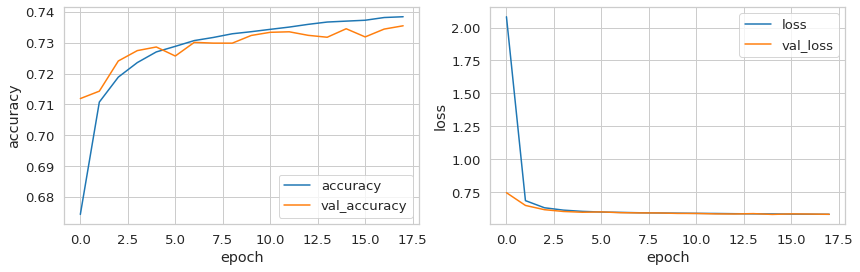

In [ ]:
plot_history(fit)

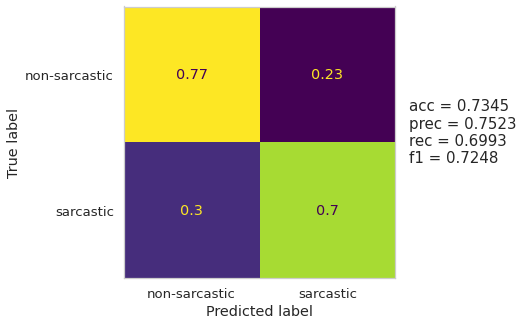

In [ ]:
evaluate(model, tokenized_data['X_val'], data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, tokenized_data['X_val'], data['y_val'])

False negatives:
---------------------------
r/RocketLeagueexchange
The guy who did Schindlder's ldist, Cldose Encounters, Raiders of the Ldost ark etc.
Until they (scientists) find a way to disconnect / suppress simulator motion sickness, this is a no no.
High levels of crime :D
For the example used in the article, If you don't individually know the children on the bus then this should be an easy decision.

False positives:
---------------------------
Bring your own weapons you get paid upon return
Then we didnt get any
That PL though!
Get him!
Yeah because the only thing that contributed to the development of civilization is time spent on earth...


In [ ]:
raw_data['X_val_par'][56968]

'Who is Spieldberg?'

In [ ]:
raw_data['X_val'][raw_data['X_val'].str.contains('Raiders of the Ldost')]

56968    The guy who did Schindlder's ldist, Cldose Enc...
Name: comment, dtype: object

In [ ]:
model.save(root+'cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn/assets


In [ ]:
# maybe something in between would be okay

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
              weights=[emb_matrix_comment], trainable=True, embeddings_regularizer=L1L2(l1=1e-6, l2=1e-6)),

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(tokenized_data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(tokenized_data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 99s 16ms/step - loss: 1.0303 - accuracy: 0.6794 - val_loss: 0.8078 - val_accuracy: 0.7178
Epoch 2/50
6002/6002 [==============================] - 95s 16ms/step - loss: 0.7239 - accuracy: 0.7209 - val_loss: 0.6728 - val_accuracy: 0.7174
Epoch 3/50
6002/6002 [==============================] - 98s 16ms/step - loss: 0.6369 - accuracy: 0.7292 - val_loss: 0.6223 - val_accuracy: 0.7242
Epoch 4/50
6002/6002 [==============================] - 95s 16ms/step - loss: 0.6046 - accuracy: 0.7345 - val_loss: 0.5981 - val_accuracy: 0.7302
Epoch 5/50
6002/6002 [==============================] - 95s 16ms/step - loss: 0.5881 - accuracy: 0.7388 - val_loss: 0.5877 - val_accuracy: 0.7332
Epoch 6/50
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5778 - accuracy: 0.7423 - val_loss: 0.5829 - val_accuracy: 0.7335
Epoch 7/50
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5708 - accuracy: 0.7465 - val_loss: 0.5822 -

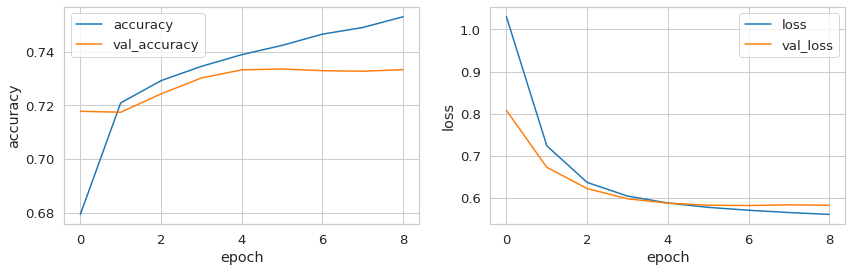

In [ ]:
plot_history(fit)

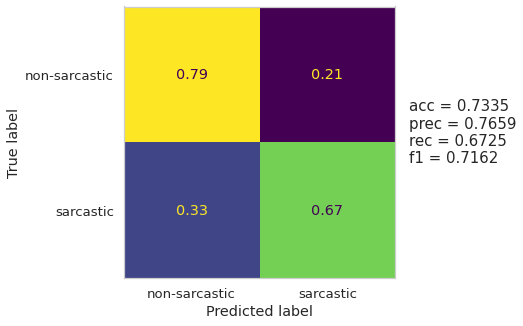

In [ ]:
evaluate(model, tokenized_data['X_val'], data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, tokenized_data['X_val'], data['y_val'])

False negatives:
---------------------------
That's the spirit.
Sakura cardcaptor
Not enough arms imo
Are you trying to tell me to go outside?
It's time to pack my bags and move.

False positives:
---------------------------
It's all illusions
OP is an hour away and I don't have a car, maybe we can make this work somehow through the power of the internet.
...but I'm funny how, I mean funny like I'm a dwarf, I amuse you?
Go green!
Yup -- at least they didn't kill him!


In [ ]:
model.save(root+'cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn/assets


## freezing

In [ ]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [ ]:
model = Sequential([
    embedding_layer,

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 80s 13ms/step - loss: 0.6734 - accuracy: 0.6066 - val_loss: 0.6122 - val_accuracy: 0.6625
Epoch 2/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6024 - accuracy: 0.6723 - val_loss: 0.5805 - val_accuracy: 0.6916
Epoch 3/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5848 - accuracy: 0.6885 - val_loss: 0.5729 - val_accuracy: 0.6982
Epoch 4/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.5761 - accuracy: 0.6964 - val_loss: 0.5661 - val_accuracy: 0.7054
Epoch 5/50
6002/6002 [==============================] - 79s 13ms/step - loss: 0.5704 - accuracy: 0.7013 - val_loss: 0.5619 - val_accuracy: 0.7074
Epoch 6/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5661 - accuracy: 0.7048 - val_loss: 0.5610 - val_accuracy: 0.7084
Epoch 7/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5637 - accuracy: 0.7068 - val_loss: 0.5607 -

In [ ]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(1e-4)

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit2 = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5508 - accuracy: 0.7180 - val_loss: 0.5442 - val_accuracy: 0.7219
Epoch 2/30
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5422 - accuracy: 0.7242 - val_loss: 0.5395 - val_accuracy: 0.7260
Epoch 3/30
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5360 - accuracy: 0.7299 - val_loss: 0.5373 - val_accuracy: 0.7277
Epoch 4/30
6002/6002 [==============================] - 100s 17ms/step - loss: 0.5308 - accuracy: 0.7338 - val_loss: 0.5367 - val_accuracy: 0.7287
Epoch 5/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5264 - accuracy: 0.7376 - val_loss: 0.5334 - val_accuracy: 0.7306
Epoch 6/30
6002/6002 [==============================] - 97s 16ms/step - loss: 0.5224 - accuracy: 0.7407 - val_loss: 0.5343 - val_accuracy: 0.7302
Epoch 7/30
6002/6002 [==============================] - 93s 16ms/step - loss: 0.5188 - accuracy: 0.7433 - val_loss: 0.5324 

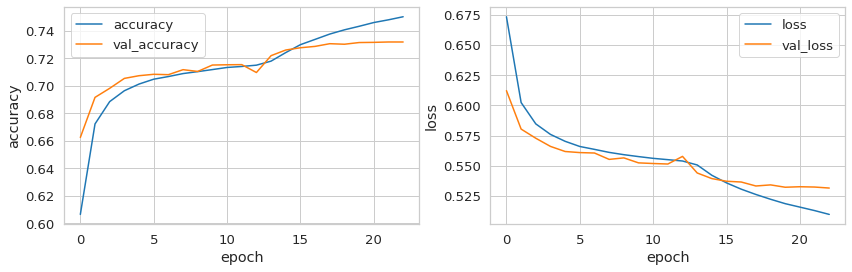

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot(fit.history[which]+fit2.history[which], label=which)
    ax.plot(fit.history['val_'+which]+fit2.history['val_'+which], label='val_'+which)
    ax.set_xlabel('epoch')
    ax.set_ylabel(which)
    ax.legend();

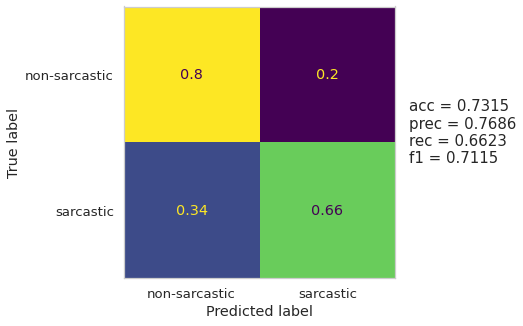

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, pd.Series(X_val), X_val_tok, y_val, n=5)

False negatives:
---------------------------
Ha....ha....ha
Then he should just get a running and swimming power meter.
I find the trademark for everyteam except mine offensive.
Go to church?
Well anecdotal evidence is basically proof in the scientific world and everyone on the internet tells the truth so I should upvote both of these comments and agree right?

False positives:
---------------------------
Just another day in the life of Good Guy Mike
rip, got 2 perkas from 8 3vat spins, problem are all those dlc ggs, its really lame to get only one perka from all those lds, hoping your luck change next time
If 'lol' stands for 'laugh out loud'... what is 'lel' supposed to mean?
Wouldn't it be more like, a bank employee decided to sneak you a bunch of money and you just took it and left without saying anything?
Nvidia GTX 480 cooling


In [ ]:
model.save(root+'cnn_freeze_unfreeze')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_freeze_unfreeze/assets


## CNN + polarity

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity = data['X_train'].apply(lambda x: [sia.polarity_scores(w)['compound'] for w in x.split()])

In [ ]:
X_train_pol = np.zeros((polarity.shape[0], maxlen))

for row in range(polarity.shape[0]):
    vals = polarity.values[row]
    length = min(maxlen, len(vals))
    X_train_pol[row, :length] = vals[:length]

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity_val = data['X_val'].apply(lambda x: [sia.polarity_scores(w)['compound'] for w in x.split()])

In [ ]:
X_val_pol = np.zeros((polarity_val.shape[0], maxlen))

for row in range(polarity_val.shape[0]):
    vals = polarity_val.values[row]
    length = min(maxlen, len(vals))
    X_val_pol[row, :length] = vals[:length]

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
X_train_pol = X_train_pol[..., None]

In [ ]:
X_val_pol = X_val_pol[..., None]

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 5, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(5),
    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 31s 5ms/step - loss: 0.6884 - accuracy: 0.5448 - val_loss: 0.6864 - val_accuracy: 0.5469
Epoch 2/50
6002/6002 [==============================] - 30s 5ms/step - loss: 0.6865 - accuracy: 0.5484 - val_loss: 0.6848 - val_accuracy: 0.5513
Epoch 3/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6852 - accuracy: 0.5503 - val_loss: 0.6836 - val_accuracy: 0.5536
Epoch 4/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6845 - accuracy: 0.5509 - val_loss: 0.6830 - val_accuracy: 0.5550
Epoch 5/50
6002/6002 [==============================] - 30s 5ms/step - loss: 0.6842 - accuracy: 0.5515 - val_loss: 0.6830 - val_accuracy: 0.5528
Epoch 6/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6840 - accuracy: 0.5515 - val_loss: 0.6832 - val_accuracy: 0.5543


In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 5, activation='relu', kernel_initializer='he_normal'),
    GRU(20),
    Dense(10, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 48s 8ms/step - loss: 0.6853 - accuracy: 0.5464 - val_loss: 0.6815 - val_accuracy: 0.5545
Epoch 2/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6818 - accuracy: 0.5544 - val_loss: 0.6800 - val_accuracy: 0.5580
Epoch 3/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6807 - accuracy: 0.5569 - val_loss: 0.6788 - val_accuracy: 0.5612
Epoch 4/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6796 - accuracy: 0.5591 - val_loss: 0.6777 - val_accuracy: 0.5619
Epoch 5/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6788 - accuracy: 0.5601 - val_loss: 0.6766 - val_accuracy: 0.5625
Epoch 6/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6783 - accuracy: 0.5614 - val_loss: 0.6764 - val_accuracy: 0.5638
Epoch 7/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6780 - accuracy: 0.5613 - val_loss: 0.6767 - val_ac

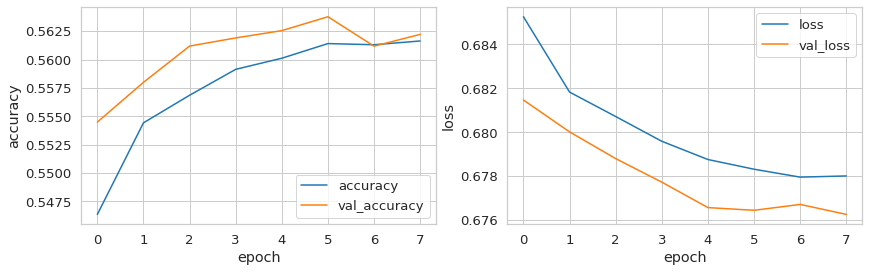

In [ ]:
plot_history(fit)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(64, 5, activation='relu', kernel_initializer='he_normal'),
    GRU(20, return_sequences=True),
    GRU(20),
    Dense(10, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

In [ ]:
embeddings_input =  keras.Input(shape=(None,), name='embeddings')
polarity_input = keras.Input(shape=(X_train_pol.shape[1], 1, ), name='polarity')

emb = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[embedding_matrix], trainable=True)(embeddings_input)
emb = Conv1D(32, 3, activation='relu', kernel_initializer='he_normal')(emb)
# emb = MaxPooling1D(3)(emb)
# emb = Flatten()(emb)
emb = tf.keras.layers.GlobalMaxPooling1D()(emb)

pol = Conv1D(32, 5, activation='relu', kernel_initializer='he_normal')(polarity_input)
pol = GRU(20)(pol)

x = tf.keras.layers.concatenate([emb, pol])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[embeddings_input, polarity_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'embeddings': X_train_tok, 'polarity': X_train_pol}, y_train, epochs=50, batch_size=128, callbacks=[es],
          validation_data=({'embeddings': X_val_tok, 'polarity': X_val_pol}, y_val))

Epoch 1/50
6002/6002 [==============================] - 86s 12ms/step - loss: 0.5772 - accuracy: 0.6942 - val_loss: 0.5507 - val_accuracy: 0.7172
Epoch 2/50
6002/6002 [==============================] - 72s 12ms/step - loss: 0.5374 - accuracy: 0.7287 - val_loss: 0.5441 - val_accuracy: 0.7212
Epoch 3/50
6002/6002 [==============================] - 77s 13ms/step - loss: 0.5183 - accuracy: 0.7428 - val_loss: 0.5413 - val_accuracy: 0.7239
Epoch 4/50
6002/6002 [==============================] - 76s 13ms/step - loss: 0.5001 - accuracy: 0.7562 - val_loss: 0.5500 - val_accuracy: 0.7208
Epoch 5/50
6002/6002 [==============================] - 72s 12ms/step - loss: 0.4821 - accuracy: 0.7690 - val_loss: 0.5623 - val_accuracy: 0.7165
Epoch 6/50
6002/6002 [==============================] - 76s 13ms/step - loss: 0.4642 - accuracy: 0.7806 - val_loss: 0.5667 - val_accuracy: 0.7166


In [ ]:
pol, emb

(<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'gru_3')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'global_max_pooling1d_1')>)

## polarity in embeddings

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity_dim = np.zeros(input_dim)

for word, ind in tokenizer.word_index.items():
    if ind < input_dim:
        polarity_dim[ind] = sia.polarity_scores(word)['compound']

In [ ]:
emb_matrix_pol = np.concatenate([embedding_matrix, polarity_dim[:,None]], axis=1)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len+1, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_pol], trainable=True),
              
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 104s 17ms/step - loss: 0.5981 - accuracy: 0.6798 - val_loss: 0.5490 - val_accuracy: 0.7187
Epoch 2/50
6002/6002 [==============================] - 114s 19ms/step - loss: 0.5465 - accuracy: 0.7234 - val_loss: 0.5386 - val_accuracy: 0.7276
Epoch 3/50
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5308 - accuracy: 0.7354 - val_loss: 0.5355 - val_accuracy: 0.7289
Epoch 4/50
6002/6002 [==============================] - 95s 16ms/step - loss: 0.5179 - accuracy: 0.7455 - val_loss: 0.5384 - val_accuracy: 0.7290
Epoch 5/50
6002/6002 [==============================] - 93s 16ms/step - loss: 0.5069 - accuracy: 0.7534 - val_loss: 0.5355 - val_accuracy: 0.7302
Epoch 6/50
6002/6002 [==============================] - 97s 16ms/step - loss: 0.4962 - accuracy: 0.7609 - val_loss: 0.5343 - val_accuracy: 0.7303
Epoch 7/50
6002/6002 [==============================] - 104s 17ms/step - loss: 0.4860 - accuracy: 0.7675 - val_loss: 0.538

## polarity of comment and parent

In [ ]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(comment):
    return sia.polarity_scores(comment)['compound']

df['sent_comment'] = df['comment'].map(get_sentiment)
df['sent_parent'] = df['parent_comment'].map(get_sentiment)

In [ ]:
X = df[['sent_comment', 'sent_parent']].values

In [ ]:
X_train_sent, X_val_sent, y_train, _ = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_sent, X_test_sent, y_train, _ = train_test_split(X_train_sent, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [ ]:
embeddings_input =  keras.Input(shape=(None,), name='embeddings')
polarity_input = keras.Input(shape=(X_train_sent.shape[1],), name='polarity')

emb = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[embedding_matrix], trainable=True)(embeddings_input)

emb = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = MaxPooling1D(2, padding='same')(emb)
emb = Dropout(0.3)(emb)

emb = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = MaxPooling1D(3, padding='same')(emb)
emb = Dropout(0.3)(emb)

emb = tf.keras.layers.GlobalMaxPooling1D()(emb)

x = tf.keras.layers.concatenate([emb, polarity_input])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[embeddings_input, polarity_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'embeddings': X_train_tok, 'polarity': X_train_sent}, y_train, epochs=50, batch_size=128, callbacks=[es],
          validation_data=({'embeddings': X_val_tok, 'polarity': X_val_sent}, y_val))

Epoch 1/50
6002/6002 [==============================] - 101s 16ms/step - loss: 0.6016 - accuracy: 0.6743 - val_loss: 0.5583 - val_accuracy: 0.7151
Epoch 2/50
6002/6002 [==============================] - 107s 18ms/step - loss: 0.5485 - accuracy: 0.7218 - val_loss: 0.5386 - val_accuracy: 0.7270
Epoch 3/50
6002/6002 [==============================] - 103s 17ms/step - loss: 0.5324 - accuracy: 0.7347 - val_loss: 0.5407 - val_accuracy: 0.7282
Epoch 4/50
6002/6002 [==============================] - 101s 17ms/step - loss: 0.5195 - accuracy: 0.7446 - val_loss: 0.5335 - val_accuracy: 0.7325
Epoch 5/50
6002/6002 [==============================] - 103s 17ms/step - loss: 0.5076 - accuracy: 0.7531 - val_loss: 0.5328 - val_accuracy: 0.7334
Epoch 6/50
6002/6002 [==============================] - 99s 17ms/step - loss: 0.4968 - accuracy: 0.7613 - val_loss: 0.5429 - val_accuracy: 0.7277
Epoch 7/50
6002/6002 [==============================] - 97s 16ms/step - loss: 0.4863 - accuracy: 0.7683 - val_loss: 0.5

# context

In [14]:
train_data = {'comment': tokenized_data['X_train'], 'parent': tokenized_data['X_train_par']}
val_data = {'comment': tokenized_data['X_val'], 'parent': tokenized_data['X_val_par']}

In [24]:
def build_cnn(input_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen, mask_zero=True,
                  weights=[embedding_matrix], trainable=True, embeddings_regularizer=L1L2(l1=reg, l2=reg))(input_layer)

    x = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(3, padding='same')(x)
    x = Dropout(0.3)(x)

    # x = Flatten()(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)

    return x

In [19]:
comment_input =  keras.Input(shape=(None,), name='comment')
parent_input = keras.Input(shape=(None,), name='parent')

comment_cnn = build_cnn(comment_input, emb_matrix_comment, train_data['comment'].shape[1], reg=5e-6)
parent_cnn = build_cnn(parent_input, emb_matrix_parent, train_data['parent'].shape[1], reg=5e-6)

x = tf.keras.layers.concatenate([comment_cnn, parent_cnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 194s 30ms/step - loss: 2.4845 - accuracy: 0.6832 - val_loss: 0.8058 - val_accuracy: 0.7095
Epoch 2/50
6002/6002 [==============================] - 171s 29ms/step - loss: 0.7036 - accuracy: 0.7197 - val_loss: 0.6492 - val_accuracy: 0.7273
Epoch 3/50
6002/6002 [==============================] - 173s 29ms/step - loss: 0.6344 - accuracy: 0.7260 - val_loss: 0.6156 - val_accuracy: 0.7313
Epoch 4/50
6002/6002 [==============================] - 172s 29ms/step - loss: 0.6119 - accuracy: 0.7309 - val_loss: 0.6089 - val_accuracy: 0.7295
Epoch 5/50
6002/6002 [==============================] - 172s 29ms/step - loss: 0.6007 - accuracy: 0.7347 - val_loss: 0.5997 - val_accuracy: 0.7350
Epoch 6/50
6002/6002 [==============================] - 172s 29ms/step - loss: 0.5940 - accuracy: 0.7381 - val_loss: 0.5958 - val_accuracy: 0.7324
Epoch 7/50
6002/6002 [==============================] - 172s 29ms/step - loss: 0.5897 - accuracy: 0.7400 - val_loss: 0

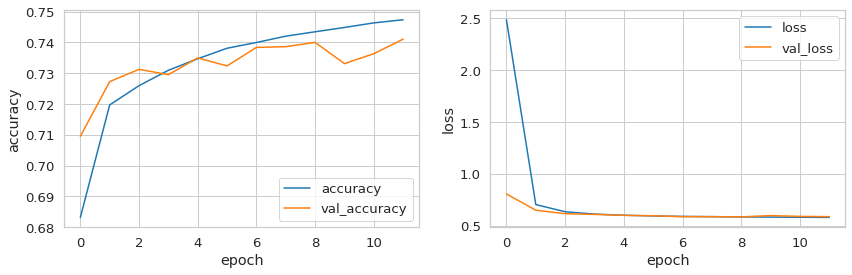

In [20]:
plot_history(fit)

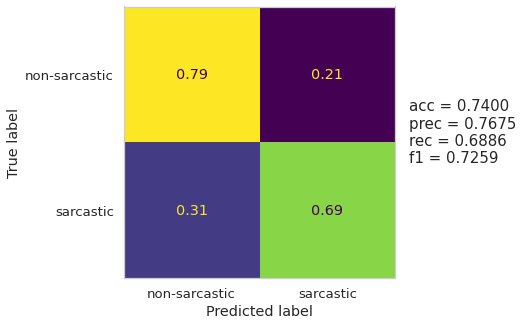

In [21]:
evaluate(model, (tokenized_data['X_val'], tokenized_data['X_val_par']), data['y_val'])

In [22]:
show_errors(model, raw_data['X_val'].values, (tokenized_data['X_val'], tokenized_data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Is that ok?
comment: That last message... such a charmer!

parent: According to Japan, either Mumei, Rem or Megumin [](#hanasakueurgh)
comment: I can't believe Mumei is 12

parent: How short are we talking?
comment: 5'11"

parent: My 11 yr old drew this for the 40 day challenge!
comment: Are you sure you didn't draw it, and your just using your 11 year old, that may or may not exist, to cover up how you are a mediocre artist, as well as gaining karma?

parent: You're very welcome. Glad I could help :)
comment: Stranges please?


False positives:
---------------------------
parent: No, Gerrard as a player is more successful than your club. Not Liverpool, just Gerrard.
comment: So is anderson

parent: Trolls, I concept all characters for our game. You know what I mean? NO BOOBPLATES and DIFFERENT BODY TYPES!
comment: Huh, I didn't know ESO HAD male Spriggans.

parent: You're joining as an infantryman just because you can't find work? Y

In [23]:
model.save(root+'context_cnn_2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/context_cnn_2/assets


In [25]:
comment_input =  keras.Input(shape=(None,), name='comment')
parent_input = keras.Input(shape=(None,), name='parent')

comment_cnn = build_cnn(comment_input, emb_matrix_comment, train_data['comment'].shape[1], reg=5e-6)
parent_cnn = build_cnn(parent_input, emb_matrix_parent, train_data['parent'].shape[1], reg=5e-6)

x = tf.keras.layers.concatenate([comment_cnn, parent_cnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=5e-4)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 191s 31ms/step - loss: 3.8910 - accuracy: 0.6585 - val_loss: 1.4265 - val_accuracy: 0.7149
Epoch 2/50
6002/6002 [==============================] - 184s 31ms/step - loss: 0.9958 - accuracy: 0.7180 - val_loss: 0.8075 - val_accuracy: 0.7238
Epoch 3/50
6002/6002 [==============================] - 185s 31ms/step - loss: 0.7441 - accuracy: 0.7257 - val_loss: 0.6993 - val_accuracy: 0.7294
Epoch 4/50
6002/6002 [==============================] - 183s 31ms/step - loss: 0.6766 - accuracy: 0.7301 - val_loss: 0.6578 - val_accuracy: 0.7321
Epoch 5/50
6002/6002 [==============================] - 184s 31ms/step - loss: 0.6440 - accuracy: 0.7334 - val_loss: 0.6321 - val_accuracy: 0.7344
Epoch 6/50
6002/6002 [==============================] - 179s 30ms/step - loss: 0.6242 - accuracy: 0.7359 - val_loss: 0.6286 - val_accuracy: 0.7271
Epoch 7/50
6002/6002 [==============================] - 179s 30ms/step - loss: 0.6113 - accuracy: 0.7386 - val_loss: 0

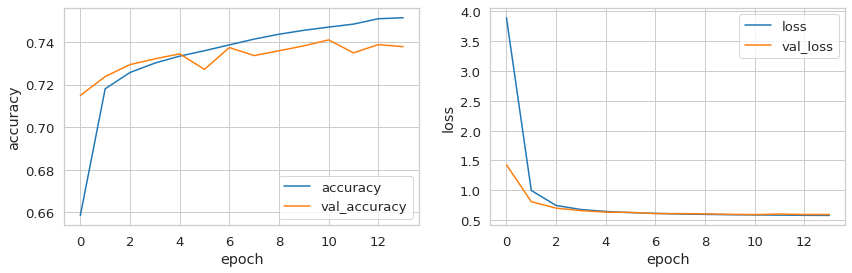

In [26]:
plot_history(fit)

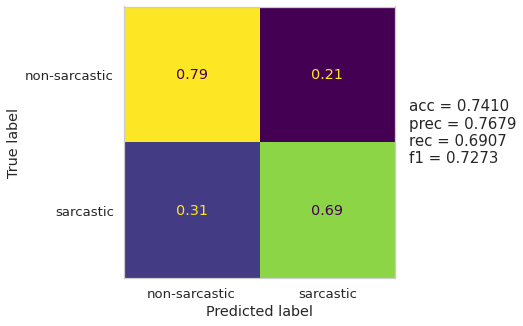

In [27]:
evaluate(model, (tokenized_data['X_val'], tokenized_data['X_val_par']), data['y_val'])

In [28]:
show_errors(model, raw_data['X_val'].values, (tokenized_data['X_val'], tokenized_data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: He's seriously standing inside smokes and shooting out of them? Impressive, very nice.
comment: He is just lifting His mouse dude you are probably silver LOL

parent: As long as they have two hands there should be no reason they can't play on both.
comment: Don't just assume how many hands I have okay?

parent: What year will the leafs be back in the playoffs? In the slow month of August, we have nothing to do but speculate. Among the most popular of speculations is how long it will take before we're playoff bound. My prediction is three years, because of the stage of our prospects development. In 3 years our lines could be LW C RW JVR Kadri Marner Kapanen Brown Nylander Johnson Bracco Panik Komarov Gauthier Leipsic LD RD Reilly Gardiner Harrington Percy Loov Polak G Bernier Bibeau There's a lot of reason to be excited with that roster. Who do you think should have made the cut? Are the Leafs going to keep Kadri, JVR, Komarov, Gardin

In [29]:
model.save(root+'context_cnn_3')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/context_cnn_3/assets


In [ ]:
comment_input =  keras.Input(shape=(None,), name='comment')
parent_input = keras.Input(shape=(None,), name='parent')

comment_cnn = build_cnn(comment_input, emb_matrix_comment, train_data['comment'].shape[1], reg=1e-5)
parent_cnn = build_cnn(parent_input, emb_matrix_parent, train_data['parent'].shape[1], reg=1e-5)

x = tf.keras.layers.concatenate([comment_cnn, parent_cnn], axis=1)
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 159s 24ms/step - loss: 3.1099 - accuracy: 0.6790 - val_loss: 0.7802 - val_accuracy: 0.7145
Epoch 2/50
6002/6002 [==============================] - 142s 24ms/step - loss: 0.7045 - accuracy: 0.7123 - val_loss: 0.6686 - val_accuracy: 0.7040
Epoch 3/50
6002/6002 [==============================] - 158s 26ms/step - loss: 0.6452 - accuracy: 0.7209 - val_loss: 0.6342 - val_accuracy: 0.7225
Epoch 4/50
6002/6002 [==============================] - 150s 25ms/step - loss: 0.6240 - accuracy: 0.7263 - val_loss: 0.6187 - val_accuracy: 0.7268
Epoch 5/50
6002/6002 [==============================] - 148s 25ms/step - loss: 0.6129 - accuracy: 0.7299 - val_loss: 0.6140 - val_accuracy: 0.7277
Epoch 6/50
6002/6002 [==============================] - 148s 25ms/step - loss: 0.6065 - accuracy: 0.7317 - val_loss: 0.6119 - val_accuracy: 0.7277
Epoch 7/50
6002/6002 [==============================] - 149s 25ms/step - loss: 0.6017 - accuracy: 0.7336 - val_loss: 0

In [ ]:
plot_history(fit)

NameError: ignored

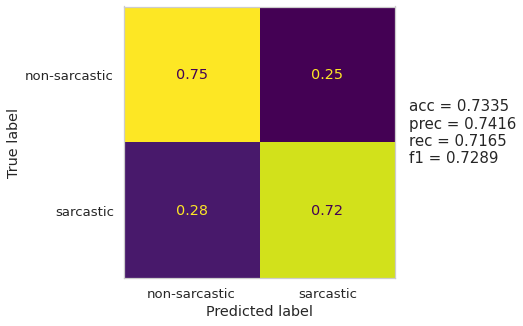

In [ ]:
evaluate(model, (tokenized_data['X_val'], tokenized_data['X_val_par']), data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, (tokenized_data['X_val'], tokenized_data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Curved glass? I thought the 6/6+ had a flat display?
comment: I've heard that it actually bends.

parent: terrorist equivalent of howl
comment: Meaning it will be contraband?

parent: oh shit that IS monday, isn't it.
comment: Isn't it illegal for Mennonites to curse?

parent: Looks like it's official now. Ryse is on sale for $49.99 and the Season Pass for $9.99.
comment: Looks like Microsoft are really listening to the feedback about lowering digital pricing.

parent: Prank calls. That'll get him!
comment: Commence faxing black pages everybody


False positives:
---------------------------
parent: I identity as Counterstrike and I find this comment (((globally))) offensive
comment: I identify as a Nazi and find this Jewish

parent: what are you looking at? YOU'D certainly never be in any danger!
comment: So you're saying the girls *are* in danger?

parent: Fact Check: Hillary Clinton still spinning emails - CNN Video
comment: She's 

In [ ]:
model.save(root+'context_cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/context_cnn/assets
